In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision, MulticlassRecall, MulticlassF1Score, MulticlassAUROC
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import numpy as np
import pandas as pd
import copy
import timm

c:\Users\Chirag Jain\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Getting the Data

In [2]:
print(os.cpu_count())

24


In [2]:
train_dir = "./Brain MRI ND-5 Dataset/tumordata/Training"
test_dir = "./Brain MRI ND-5 Dataset/tumordata/Testing"

### Transforming it to 224x224 Size

In [3]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
train_dataset = ImageFolder(train_dir, transform)
test_dataset = ImageFolder(test_dir,transform)

In [5]:
# train_loader = DataLoader( train_dataset,batch_size=32,shuffle=True,pin_memory=True,num_workers=6, drop_last=True,persistent_workers=True)
# val_loader = DataLoader(val_dataset,batch_size=32,shuffle=False,pin_memory=True,num_workers=4,persistent_workers=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False,pin_memory=True,num_workers=16,persistent_workers=True)

In [7]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 3961
    Root location: ./Brain MRI ND-5 Dataset/tumordata/Testing
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [6]:
class EfficientNet_Attention(nn.Module):
    def __init__(self, num_classes=4):
        super(EfficientNet_Attention, self).__init__()
        self.encoder = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0)  
        self.attention = nn.Sequential(
            nn.Linear(1536, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1536),
            nn.LeakyReLU(),
            nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(1536),
            nn.Linear(1536, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.7),  # Increase dropout
            nn.Linear(512, num_classes)
        )


    def forward(self, x):
        x = self.encoder(x)  # EfficientNet features
        attn = self.attention(x)  
        x = x * attn  # Apply attention weights
        x = self.classifier(x)
        return x

model = EfficientNet_Attention(num_classes=4)


In [9]:
print(model)

EfficientNet_Attention(
  (encoder): EfficientNet(
    (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn1): BatchNormAct2d(
            40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          

Loss: CrossEntropyLoss <br>
Optimizer : Adam <br>
Schedular : StepLR with 50% Learning Reduction rate <br>

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6, verbose=True)

In [11]:
NUM_CLASSES = 4
BATCH_SIZE = 16
NUM_EPOCHS = 25
K_FOLDS = 5
PATIENCE = 5
LR = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SAVE_DIR = 'checkpoints'
os.makedirs(SAVE_DIR, exist_ok=True)


In [7]:
torch.backends.cudnn.benchmark = True

Creating a function to define the model

In [ ]:
def train(model, criterion, optimizer, scheduler, k_folds=10, patience=5, 
          num_epochs=25, save_dir='checkpoints', batch_size=32, device='cuda'):

    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_model = model.to(device)
    os.makedirs(save_dir, exist_ok=True)
    all_metrics = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
        print(f"\n--- Fold {fold + 1}/{k_folds} ---")
        train_subset = Subset(train_dataset, train_idx)
        val_subset = Subset(train_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True,
                                  pin_memory=True, num_workers=18, drop_last=True, persistent_workers=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False,
                                pin_memory=True, num_workers=4, persistent_workers=True)
        accuracy = MulticlassAccuracy(num_classes=NUM_CLASSES, average='macro').to(device)
        precision = MulticlassPrecision(num_classes=NUM_CLASSES, average='macro').to(device)
        recall = MulticlassRecall(num_classes=NUM_CLASSES, average='macro').to(device)
        f1 = MulticlassF1Score(num_classes=NUM_CLASSES, average='macro').to(device)
        auc = MulticlassAUROC(num_classes=NUM_CLASSES, average='macro').to(device)

        fold_metrics = []
        best_val_loss = float('inf')
        epochs_without_improvement = 0
        early_stopping_flag = False
        best_model_wts = None

        fold_checkpoint_dir = os.path.join(save_dir, f"fold_{fold + 1}")
        os.makedirs(fold_checkpoint_dir, exist_ok=True)

        for epoch in range(num_epochs):
            if early_stopping_flag:
                print(f"Early stopping at epoch {epoch + 1}")
                break

            # ------------------ Training ------------------
            fold_model.train()
            running_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = fold_model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

                accuracy.update(outputs, labels)
                precision.update(outputs, labels)
                recall.update(outputs, labels)
                f1.update(outputs, labels)
                auc.update(outputs, labels)

            avg_train_loss = running_loss / len(train_loader)
            train_acc = accuracy.compute()
            train_prec = precision.compute()
            train_recall = recall.compute()
            train_f1 = f1.compute()
            train_auc = auc.compute()

            accuracy.reset()
            precision.reset()
            recall.reset()
            f1.reset()
            auc.reset()

            # ------------------ Validation ------------------
            fold_model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = fold_model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    accuracy.update(outputs, labels)
                    precision.update(outputs, labels)
                    recall.update(outputs, labels)
                    f1.update(outputs, labels)
                    auc.update(outputs, labels)

            avg_val_loss = val_loss / len(val_loader)
            val_acc = accuracy.compute()
            val_prec = precision.compute()
            val_recall = recall.compute()
            val_f1 = f1.compute()
            val_auc = auc.compute()
            accuracy.reset()
            precision.reset()
            recall.reset()
            f1.reset()
            auc.reset()

            if scheduler is not None:
                scheduler.step(avg_val_loss)

            print(f"Epoch {epoch + 1}/{num_epochs} | "
                  f"Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f}, Prec: {train_prec:.4f}, "
                  f"Recall: {train_recall:.4f}, F1: {train_f1:.4f}, AUC: {train_auc:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}, Prec: {val_prec:.4f}, "
                  f"Recall: {val_recall:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")

            epoch_metrics = {
                'fold': fold + 1,
                'epoch': epoch + 1,
                'train_loss': avg_train_loss,
                'train_accuracy': train_acc.item(),
                'train_precision': train_prec.item(),
                'train_recall': train_recall.item(),
                'train_f1': train_f1.item(),
                'train_auc': train_auc.item(),
                'val_loss': avg_val_loss,
                'val_accuracy': val_acc.item(),
                'val_precision': val_prec.item(),
                'val_recall': val_recall.item(),
                'val_f1': val_f1.item(),
                'val_auc': val_auc.item(),
            }

            fold_metrics.append(epoch_metrics)
            all_metrics.append(epoch_metrics)

            if avg_val_loss < best_val_loss:
                print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}")
                best_val_loss = avg_val_loss
                epochs_without_improvement = 0
                best_model_wts = copy.deepcopy(fold_model.state_dict())
                torch.save(best_model_wts, os.path.join(fold_checkpoint_dir, 'best_model.pth'))
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= patience:
                    early_stopping_flag = True

        fold_df = pd.DataFrame(fold_metrics)
        fold_df.to_csv(os.path.join(fold_checkpoint_dir, f"fold_{fold + 1}_metrics.csv"), index=False)
        fold_model.load_state_dict(best_model_wts)

    all_metrics_df = pd.DataFrame(all_metrics)
    all_metrics_df.to_csv(os.path.join(save_dir, 'kfold_metrics.csv'), index=False)

    return model, all_metrics_df


In [14]:
print(train_dataset)

Dataset ImageFolder
    Number of datapoints: 13927
    Root location: ./Brain MRI ND-5 Dataset/tumordata/Training
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [8]:
torch.cuda.empty_cache()

Model Training

In [ ]:
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

tensor(0.)

In [17]:
model,all_fold_metrics_df = train(model,criterion, optimizer, scheduler)


--- Fold 1/10 ---
Epoch 1/25 | Train Loss: 0.2807, Acc: 0.9096, Prec: 0.9095, Recall: 0.9096, F1: 0.9095, AUC: 0.9857 | Val Loss: 0.1110, Acc: 0.9644, Prec: 0.9684, Recall: 0.9644, F1: 0.9662, AUC: 0.9972
Validation loss improved from inf to 0.1110
Epoch 2/25 | Train Loss: 0.1097, Acc: 0.9670, Prec: 0.9669, Recall: 0.9670, F1: 0.9670, AUC: 0.9973 | Val Loss: 0.0874, Acc: 0.9776, Prec: 0.9739, Recall: 0.9776, F1: 0.9754, AUC: 0.9985
Validation loss improved from 0.1110 to 0.0874
Epoch 3/25 | Train Loss: 0.0797, Acc: 0.9779, Prec: 0.9781, Recall: 0.9779, F1: 0.9780, AUC: 0.9983 | Val Loss: 0.0741, Acc: 0.9834, Prec: 0.9814, Recall: 0.9834, F1: 0.9823, AUC: 0.9981
Validation loss improved from 0.0874 to 0.0741
Epoch 4/25 | Train Loss: 0.1319, Acc: 0.9705, Prec: 0.9705, Recall: 0.9705, F1: 0.9705, AUC: 0.9974 | Val Loss: 0.1635, Acc: 0.9841, Prec: 0.9854, Recall: 0.9841, F1: 0.9847, AUC: 0.9986
Epoch 5/25 | Train Loss: 1.2586, Acc: 0.8014, Prec: 0.8004, Recall: 0.8014, F1: 0.8008, AUC: 0.

In [18]:
print(all_fold_metrics_df.head())

   fold  epoch  train_loss  train_accuracy  train_precision  train_recall  \
0     1      1    0.280687        0.909571         0.909513      0.909571   
1     1      2    0.109720        0.966989         0.966925      0.966989   
2     1      3    0.079654        0.977921         0.978138      0.977921   
3     1      4    0.131871        0.970485         0.970510      0.970485   
4     1      5    1.258568        0.801378         0.800373      0.801378   

   train_f1  train_auc  val_loss  val_accuracy  val_precision  val_recall  \
0  0.909539   0.985675  0.110979      0.964415       0.968425    0.964415   
1  0.966956   0.997298  0.087406      0.977605       0.973934    0.977605   
2  0.978029   0.998276  0.074113      0.983432       0.981447    0.983432   
3  0.970497   0.997361  0.163535      0.984145       0.985350    0.984145   
4  0.800840   0.937045  1.803987      0.744216       0.795343    0.744216   

     val_f1   val_auc  
0  0.966197  0.997156  
1  0.975394  0.998532  
2 

Saving the model locally

In [19]:
torch.save(model.state_dict(), "EfficientNetAttention_tumor.pth")
print("Model saved successfully!")

Model saved successfully!


## Model Performance
Evaluating Model Performance on Testing Data

In [9]:
model.load_state_dict(torch.load("EfficientNetAttention_tumor.pth", map_location='cuda'))
model.eval()

C:\Users\Chirag Jain\AppData\Local\Temp\ipykernel_20440\3871653877.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("EfficientNetAttentio

EfficientNet_Attention(
  (encoder): EfficientNet(
    (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
          (bn1): BatchNormAct2d(
            40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          

In [11]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(DEVICE)

In [12]:
print(type(model))

<class '__main__.EfficientNet_Attention'>


In [22]:
all_fold_metrics_df

,fold,epoch,train_loss,train_accuracy,train_precision,train_recall,train_f1,train_auc,val_loss,val_accuracy,val_precision,val_recall,val_f1,val_auc
0,1,1,0.280687,0.909571,0.909513,0.909571,0.909539,0.985675,1.109789e-01,0.964415,0.968425,0.964415,0.966197,0.997156
1,1,2,0.109720,0.966989,0.966925,0.966989,0.966956,0.997298,8.740619e-02,0.977605,0.973934,0.977605,0.975394,0.998532
2,1,3,0.079654,0.977921,0.978138,0.977921,0.978029,0.998276,7.411304e-02,0.983432,0.981447,0.983432,0.982348,0.998051
3,1,4,0.131871,0.970485,0.970510,0.970485,0.970497,0.997361,1.635345e-01,0.984145,0.985350,0.984145,0.984682,0.998635
4,1,5,1.258568,0.801378,0.800373,0.801378,0.800840,0.937045,1.803987e+00,0.744216,0.795343,0.744216,0.738442,0.948739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,10,2,0.000015,1.000000,1.000000,1.000000,1.000000,1.000000,9.313181e-09,1.000000,1.000000,1.000000,1.000000,1.000000
118,10,3,0.000072,0.999882,0.999938,0.999882,0.999910,1.000000,9.821187e-09,1.000000,1.000000,1.000000,1.000000,1.000000
119,10,4,0.000005,1.000000,1.000000,1.000000,1.000000,1.000000,5.926582e-09,1.000000,1.000000,1.000000,1.000000,1.000000
120,10,5,0.000003,1.000000,1.000000,1.000000,1.000000,1.000000,9.567171e-09,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
from sklearn.metrics import precision_score, recall_score
correct = 0
total = 0
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = (2*precision*recall)/(precision+recall)
accuracy =correct / total

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

Test Accuracy: 0.9745
Test Precision: 0.9729
Test Recall: 0.9779
Test F1-Score: 0.9754


In [14]:
from torchvision.datasets import ImageFolder
from torch.utils.data import ConcatDataset

In [15]:
ext_test_ts = "./MRI Dataset (Tumor)/Testing"
ext_test_tr = "./MRI Dataset (Tumor)/Training"

ext_tr_dataset = ImageFolder(ext_test_tr,transform)
ext_ts_dataset = ImageFolder(ext_test_ts,transform)
ext_test_dataset = ConcatDataset([ext_tr_dataset,ext_ts_dataset])
ext_test_loader = DataLoader(ext_test_dataset,batch_size=32,shuffle=False,pin_memory=True,num_workers=2,persistent_workers=True)

In [16]:
from sklearn.metrics import precision_score, recall_score
correct = 0
total = 0
all_preds_ext = []
all_labels_ext = []
all_probs_ext = []

with torch.no_grad():
    for images, labels in ext_test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds_ext.extend(predicted.cpu().numpy())
        all_labels_ext.extend(labels.cpu().numpy())
        all_probs_ext.extend(probs.cpu().numpy())
all_preds_ext = np.array(all_preds_ext)
all_labels_ext = np.array(all_labels_ext)
precision = precision_score(all_labels_ext, all_preds_ext, average='macro')
recall = recall_score(all_labels_ext, all_preds_ext, average='macro')
f1 = (2*precision*recall)/(precision+recall)
accuracy =correct / total

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

Test Accuracy: 0.9980
Test Precision: 0.9979
Test Recall: 0.9979
Test F1-Score: 0.9979


# Graphical Visualisation of Loss and Accuracy Curve for each epochs

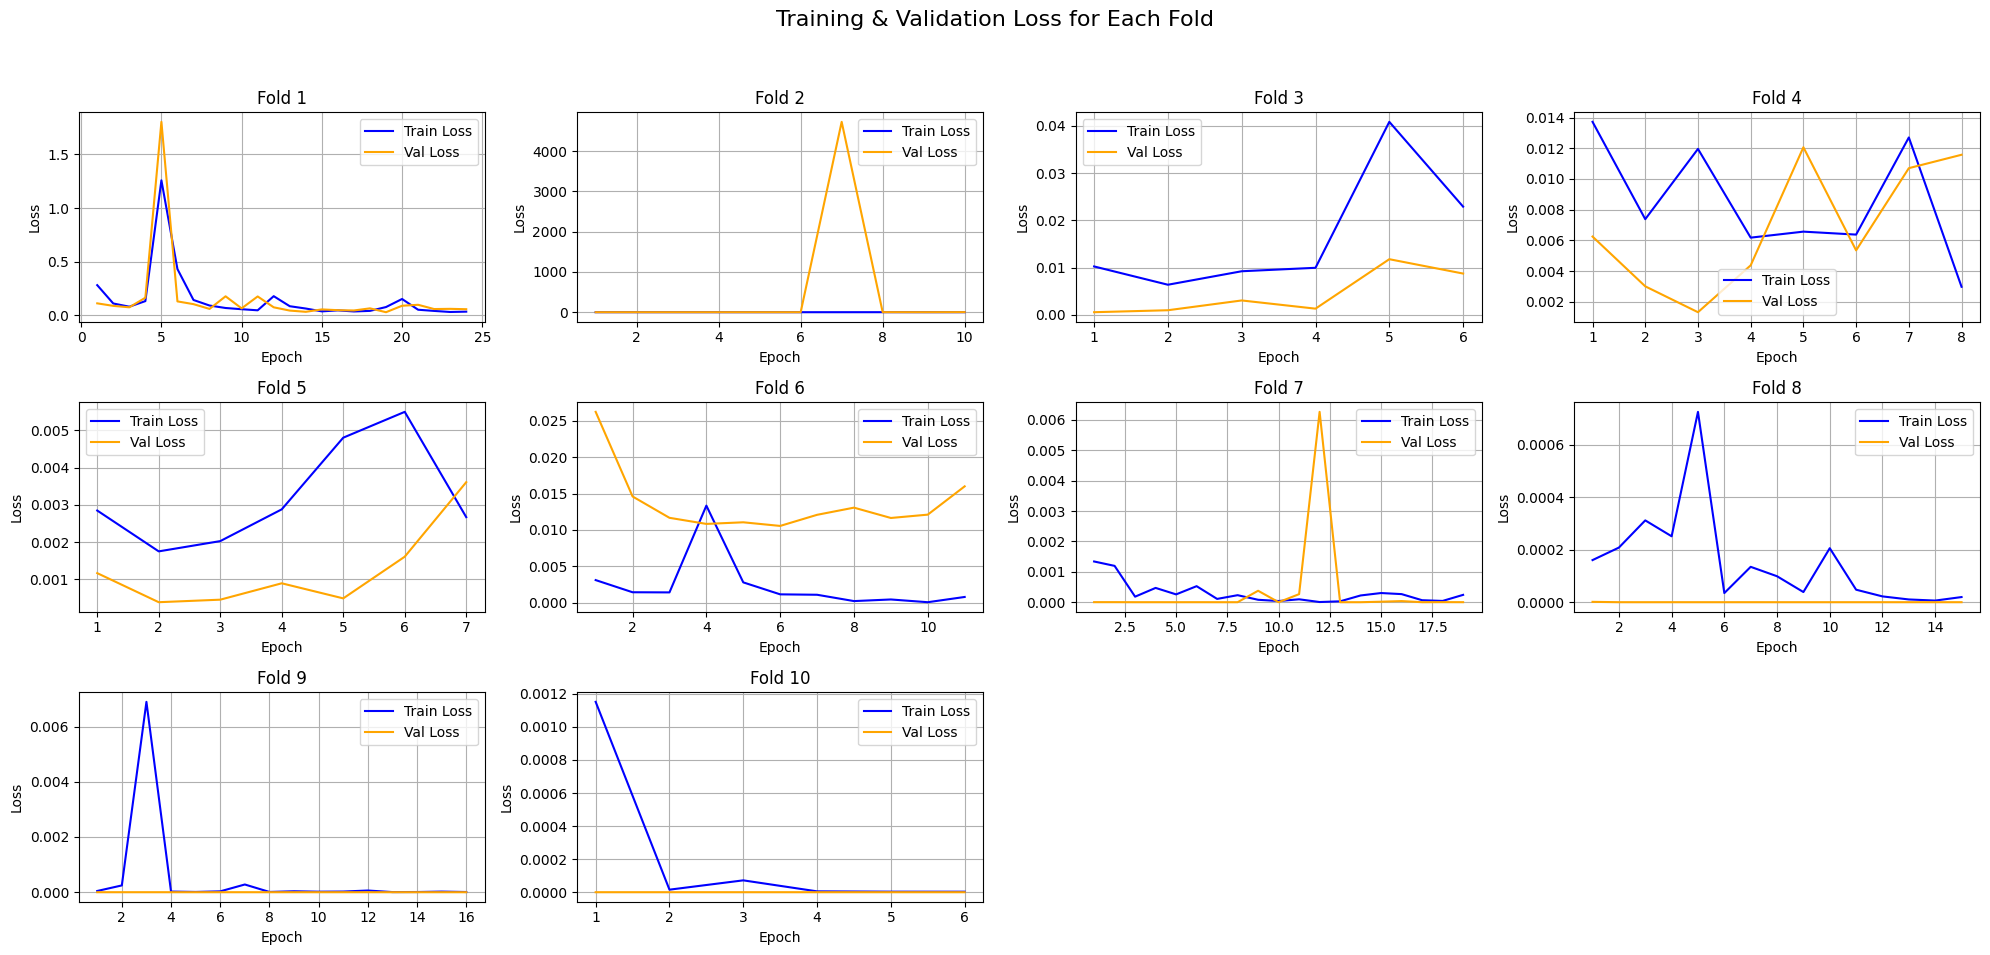

In [66]:
import matplotlib.pyplot as plt
import numpy as np

folds = sorted(all_fold_metrics_df['fold'].unique())
num_folds = len(folds)
cols = 4
rows = (num_folds + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 10), sharex=False, sharey=False)
axes = axes.flatten()  # Flatten for easy indexing

for i, fold in enumerate(folds):
    ax = axes[i]
    fold_data = all_fold_metrics_df[all_fold_metrics_df['fold'] == fold]
    
    ax.plot(fold_data['epoch'], fold_data['train_loss'], label='Train Loss', color='blue')
    ax.plot(fold_data['epoch'], fold_data['val_loss'], label='Val Loss', color='orange')
    ax.set_title(f'Fold {fold}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.grid(True)
    ax.legend()

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle('Training & Validation Loss for Each Fold', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for title
plt.show()


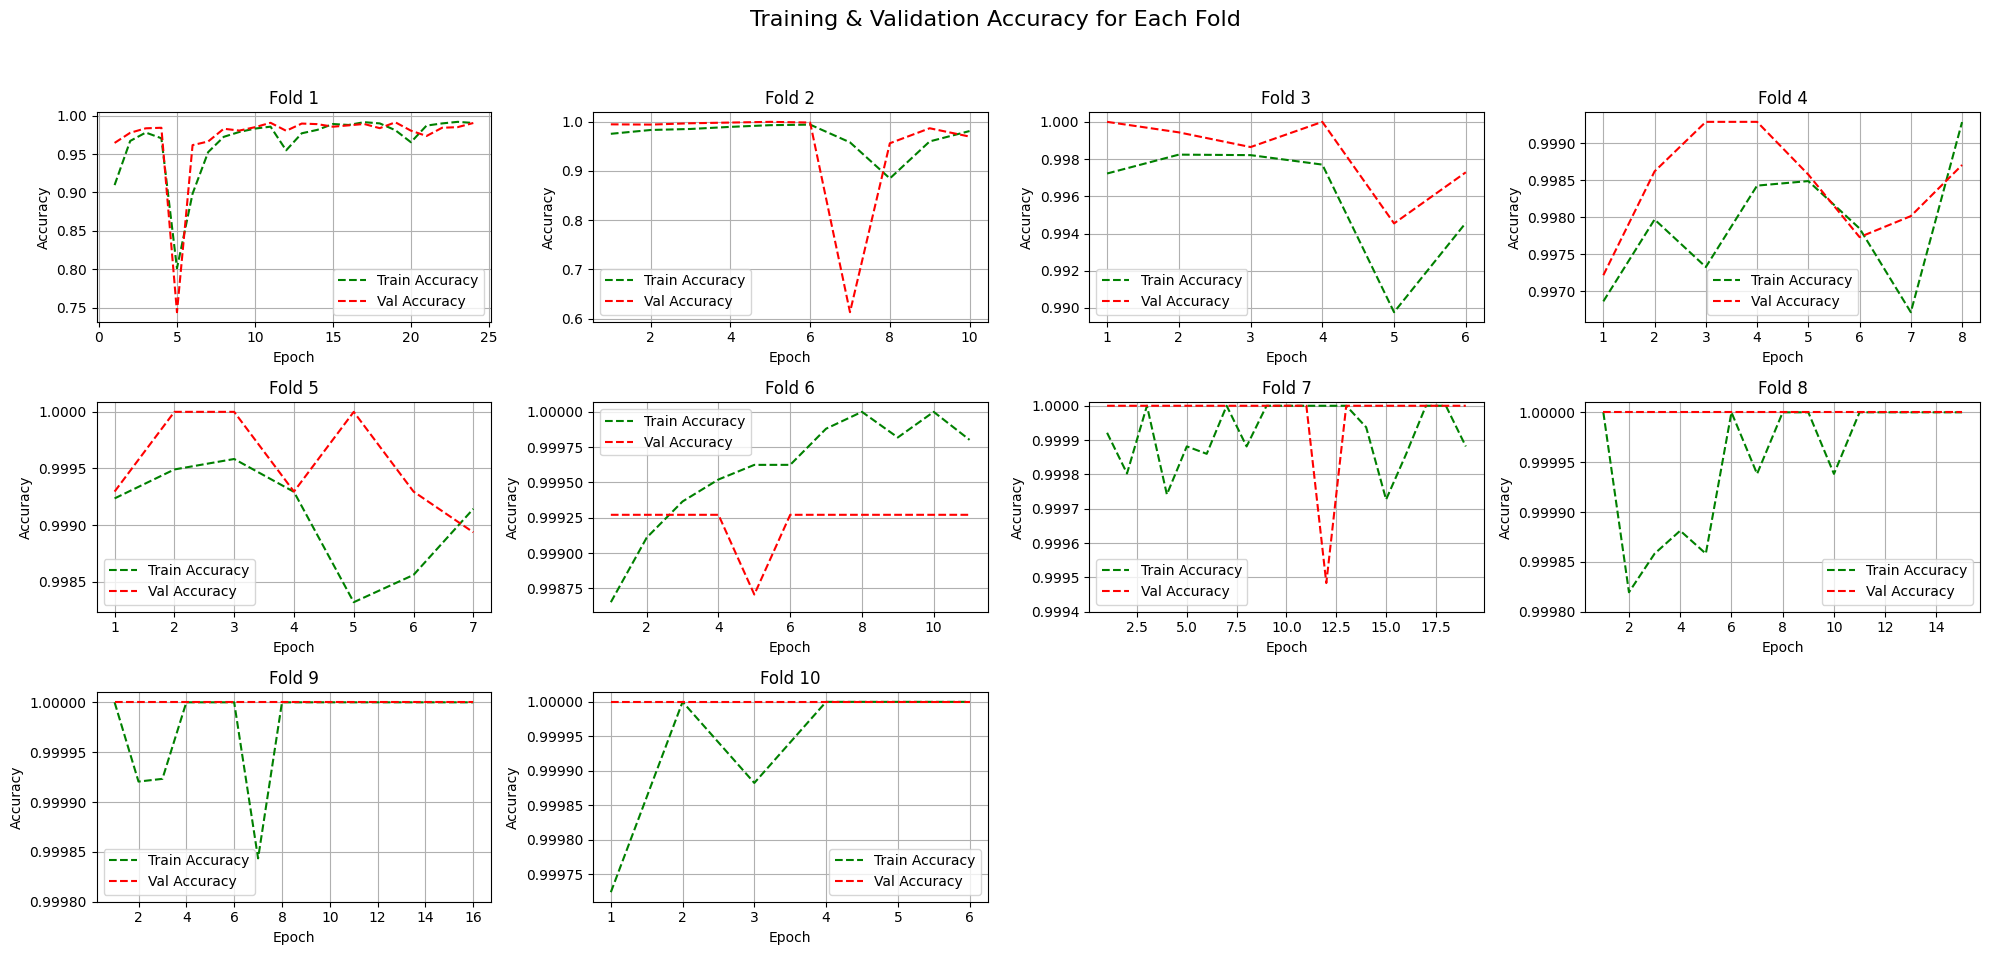

In [ ]:

folds = sorted(all_fold_metrics_df['fold'].unique())
num_folds = len(folds)
cols = 4
rows = (num_folds + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 10), sharex=False, sharey=False)
axes = axes.flatten()

for i, fold in enumerate(folds):
    
    ax = axes[i]
    fold_data = all_fold_metrics_df[all_fold_metrics_df['fold'] == fold]
    ax.plot(fold_data['epoch'], fold_data['train_accuracy'], label='Train Accuracy', color='green', linestyle='--')
    ax.plot(fold_data['epoch'], fold_data['val_accuracy'], label='Val Accuracy', color='red', linestyle='--')

    ax.set_title(f'Fold {fold}')
    if(fold >= 7 and fold <10):
        if(fold == 8 or fold == 9):
            ax.set_ylim(0.9998,1.00001)
        else:
            ax.set_ylim(0.9994,1.00001)
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.grid(True)
    ax.legend()
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle('Training & Validation Accuracy for Each Fold', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()


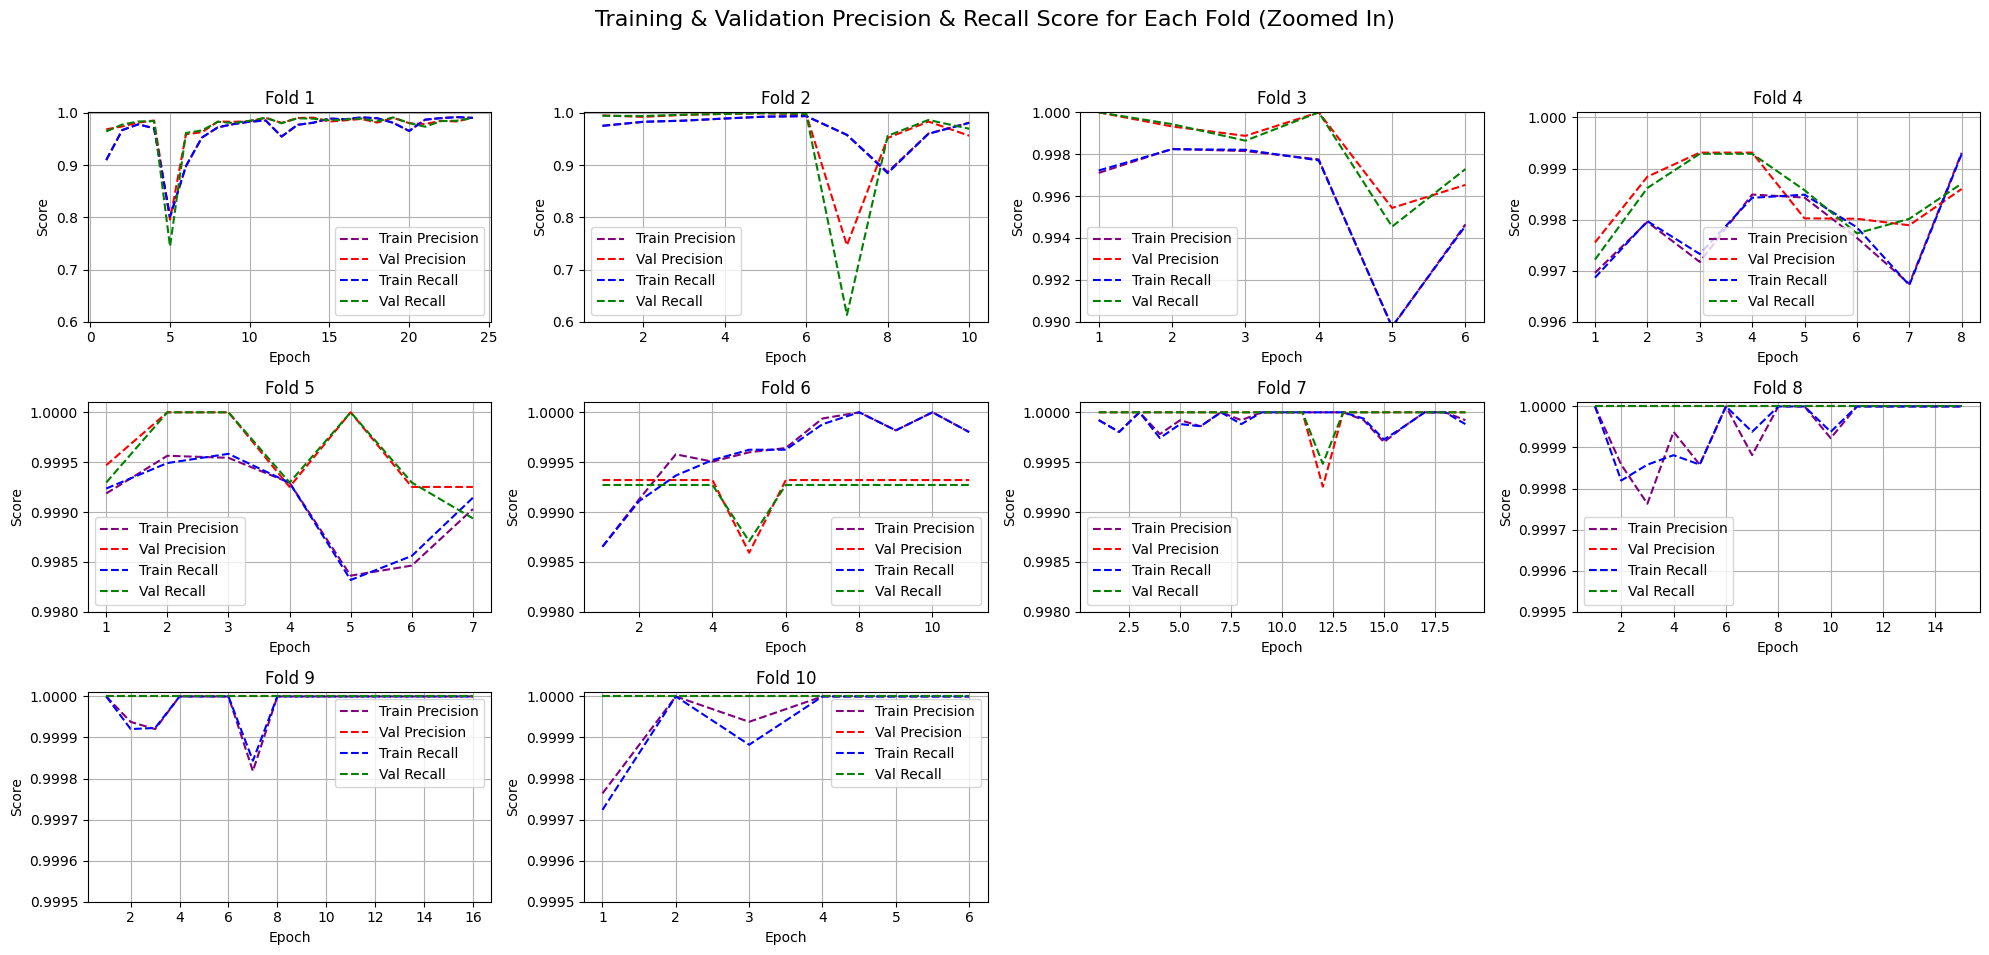

In [ ]:

folds = sorted(all_fold_metrics_df['fold'].unique())
num_folds = len(folds)
cols = 4
rows = (num_folds + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(20, 10), sharex=False, sharey=False)
axes = axes.flatten()

for i, fold in enumerate(folds):
    
    ax = axes[i]
    fold_data = all_fold_metrics_df[all_fold_metrics_df['fold'] == fold]
    ax.plot(fold_data['epoch'], fold_data['train_precision'], label='Train Precision', color='purple', linestyle='--')
    ax.plot(fold_data['epoch'], fold_data['val_precision'], label='Val Precision', color='red', linestyle='--')
    ax.plot(fold_data['epoch'], fold_data['train_recall'], label='Train Recall', color='blue', linestyle='--')
    ax.plot(fold_data['epoch'], fold_data['val_recall'], label='Val Recall', color='green', linestyle='--')

    ax.set_title(f'Fold {fold}')
    if(fold <=2): 
        ax.set_ylim(0.6,1.001)
    elif(fold == 3):
        ax.set_ylim(0.99,1)
    elif fold == 4: 
        ax.set_ylim(0.996,1.0001)
    elif fold >= 8:
        ax.set_ylim(0.9995,1.00001)
    else:
        ax.set_ylim(0.998,1.0001)
    ax.set_ylabel('Score')
    ax.set_xlabel('Epoch')
    ax.grid(True)
    ax.legend()
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle('Training & Validation Precision & Recall Score for Each Fold (Zoomed In)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()


Confusion Matrix for each class

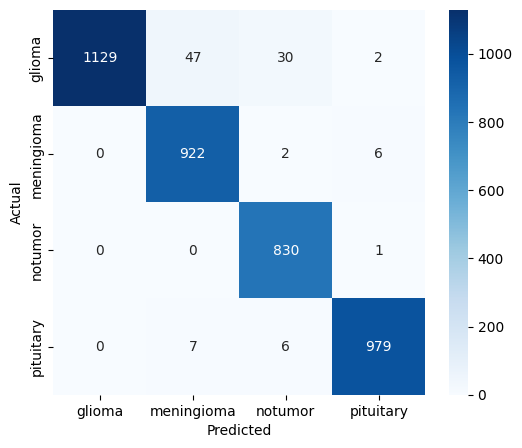

In [17]:
class_names = os.listdir("./MRI Dataset (Tumor)/Training")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


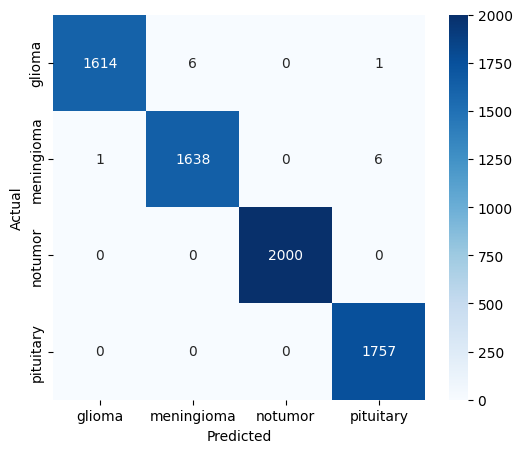

In [18]:

class_names = os.listdir("./MRI Dataset (Tumor)/Training")
cm = confusion_matrix(all_labels_ext, all_preds_ext)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Classification Report

In [120]:

print(classification_report(all_labels, all_preds, target_names=class_names))


              precision    recall  f1-score   support

      glioma       1.00      0.93      0.97      1208
  meningioma       0.94      0.99      0.97       930
     notumor       0.96      1.00      0.98       831
   pituitary       0.99      0.99      0.99       992

    accuracy                           0.97      3961
   macro avg       0.97      0.98      0.97      3961
weighted avg       0.98      0.97      0.97      3961



In [121]:

print(classification_report(all_labels_ext, all_preds_ext, target_names=class_names))


              precision    recall  f1-score   support

      glioma       1.00      1.00      1.00      1321
  meningioma       1.00      1.00      1.00      1339
     notumor       1.00      1.00      1.00      1595
   pituitary       1.00      1.00      1.00      1457

    accuracy                           1.00      5712
   macro avg       1.00      1.00      1.00      5712
weighted avg       1.00      1.00      1.00      5712



ROC and AUC Curve for each Class

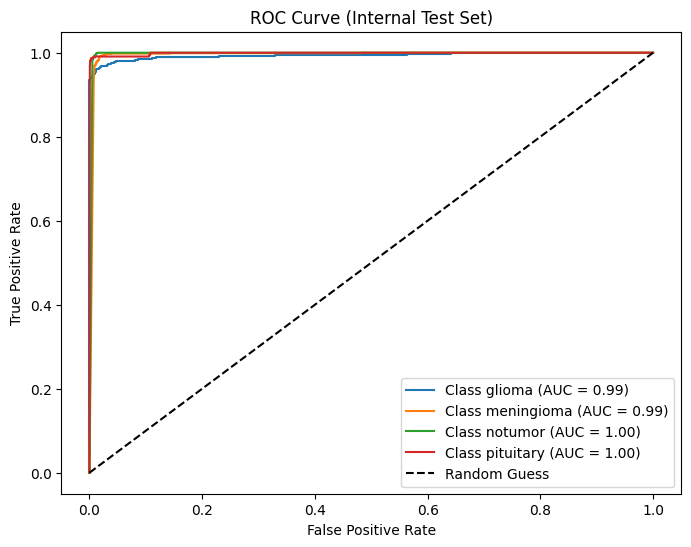

In [ ]:
all_labels_onehot = label_binarize(all_labels, classes=[0, 1, 2, 3])
all_preds_probs = np.array(all_probs)
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(all_labels_onehot[:, i], all_preds_probs[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {class_names[i]} (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Internal Test Set)")
plt.legend()
plt.show()


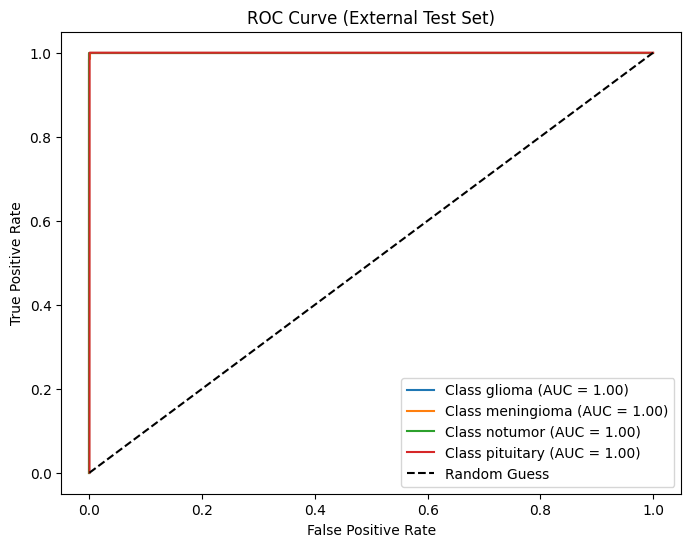

In [ ]:
all_labels_onehot_ext = label_binarize(all_labels_ext, classes=[0, 1, 2, 3])
all_preds_probs_ext = np.array(all_probs_ext)
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(all_labels_onehot_ext[:, i], all_preds_probs_ext[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {class_names[i]} (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (External Test Set)")
plt.legend()
plt.show()